In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install -q git+https://github.com/vasudevgupta7/gsoc-wav2vec2@main
!sudo apt-get install -y libsndfile1-dev
!pip3 install -q SoundFile

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1-dev is already the newest version (1.0.28-4ubuntu0.18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import os

import tensorflow as tf
import tensorflow_hub as hub
from wav2vec2 import Wav2Vec2Config

config = Wav2Vec2Config()

print("TF version:", tf.__version__)

TF version: 2.8.0


In [ ]:
pretrained_layer = hub.KerasLayer("https://tfhub.dev/vasudevgupta7/wav2vec2/1", trainable=True)

In [ ]:
AUDIO_MAXLEN = 246000
LABEL_MAXLEN = 256
BATCH_SIZE = 2

In [ ]:
speech  = tf.keras.Input(shape=(AUDIO_MAXLEN,))
hidden_states = pretrained_layer(speech)
outputs = tf.keras.layers.Dense(1040)(hidden_states)

model = tf.keras.Model(speech, outputs=outputs)

In [ ]:
model(tf.random.uniform(shape=(BATCH_SIZE, AUDIO_MAXLEN)))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 246000)]          0         
                                                                 
 keras_layer (KerasLayer)    (None, 768, 768)          94371712  
                                                                 
 dense (Dense)               (None, 768, 1040)         799760    
                                                                 
Total params: 95,171,472
Trainable params: 95,171,472
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from wav2vec2 import CTCLoss

LEARNING_RATE = 5e-5

loss_fn = CTCLoss(config, (BATCH_SIZE, AUDIO_MAXLEN), division_factor=BATCH_SIZE)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [ ]:
data_dir = "/content/drive/MyDrive/상담 음성/Training/D61/J92"

all_files = os.listdir(data_dir)
all_files.sort()

In [ ]:

for folder_name in all_files :                                                  
    file_path = data_dir + "/" + folder_name                                   
    
    file_list = os.listdir(file_path)                                             
    file_list.sort()

    
    count = 1
    count_t = 1
    for file_name in file_list :
      if '.wav' in file_name:
        old_name = file_path + "/" + file_name                                    
        new_name = file_path + "/" + folder_name[-5:] + str(count).zfill(4) + ".wav"
        try:
            os.rename(old_name, new_name)
            
        except:
            print('fail')
        count = count + 1

      else: 
        old_name = file_path + "/" + file_name                                    
        new_name = file_path + "/" +folder_name[-5:]+ str(count_t).zfill(4) + ".txt"
        try:
            os.rename(old_name, new_name)
            
        except:
            print('fail') 
        count_t = count_t + 1



In [ ]:

wav_files = [i for f in all_files[:500] for i in os.listdir(data_dir+'/'+f) if i.endswith(".wav")]
txt_files = [i for f in all_files[:500] for i in os.listdir(data_dir+'/'+f) if i.endswith(".txt")]

print("Transcription files:", txt_files[:30], "\nSound files:", wav_files[:30])

Transcription files: ['082790001.txt', '082790002.txt', '082790003.txt', '082790004.txt', '082790005.txt', '082790006.txt', '082790007.txt', '082790008.txt', '082790009.txt', '082790010.txt', '082790011.txt', '082790012.txt', '082790013.txt', '082790014.txt', '082790015.txt', '082790016.txt', '082790017.txt', '082790018.txt', '082790019.txt', '082790020.txt', '082790021.txt', '082790022.txt', '082790023.txt', '082790024.txt', '082790025.txt', '082790026.txt', '082790027.txt', '082800001.txt', '082800002.txt', '082800003.txt'] 
Sound files: ['082790001.wav', '082790002.wav', '082790003.wav', '082790004.wav', '082790005.wav', '082790006.wav', '082790007.wav', '082790008.wav', '082790009.wav', '082790010.wav', '082790011.wav', '082790012.wav', '082790013.wav', '082790014.wav', '082790015.wav', '082790016.wav', '082790017.wav', '082790018.wav', '082790019.wav', '082790020.wav', '082790021.wav', '082790022.wav', '082790023.wav', '082790024.wav', '082790025.wav', '082790026.wav', '082800001.

In [ ]:
def read_txt_file(f):
  file_id = os.path.split(f)[-1][:-len(".txt")]
  with open(f, "r") as f:
    samples = f.read().split("\n")
    samples = {file_id: " ".join(s.split()[1:]) for s in samples if len(s.split()) > 2}
  return samples

In [ ]:
import soundfile as sf

REQUIRED_SAMPLE_RATE = 8000

def read_wav_file(file_path):
  with open(file_path, "rb") as f:
      audio, sample_rate = sf.read(f)
  if sample_rate != REQUIRED_SAMPLE_RATE:
      raise ValueError(
          f"sample rate (={sample_rate}) of your files must be {REQUIRED_SAMPLE_RATE}"
      )
  file_id = os.path.split(file_path)[-1][:-len(".wav")]
  return {file_id: audio}

In [ ]:
from IPython.display import Audio
import random

file_id = random.choice([f[:-len(".wav")] for f in wav_files])
wav_file_path, txt_file_path = os.path.join(data_dir, f"S000{file_id[0:5]}/{file_id}.wav"), os.path.join(data_dir,  f"S000{file_id[0:5]}/{file_id}.txt")

print("Text Transcription:", read_txt_file(txt_file_path), "\nAudio:")
Audio(filename=wav_file_path)

Text Transcription: {'084340031': '네, 아/ 일단 알겠습니다. 답답해도 뭐/ 연락을 먼저 해봐야겠네요.'} 
Audio:


In [ ]:
def fetch_sound_text_mapping(data_dir):
  all_files = os.listdir(data_dir)
  all_files.sort()
  wav_files = [i for f in all_files[:777] for i in os.listdir(data_dir+'/'+f) if i.endswith(".wav")]
  txt_files = [i for f in all_files[:777] for i in os.listdir(data_dir+'/'+f) if i.endswith(".txt")]

  txt_samples = {}
  for f in txt_files:
    txt_samples.update(read_txt_file(data_dir+'/'+f"S000{f[0:5]}/"+f))

  speech_samples = {}
  for f in wav_files:
    speech_samples.update(read_wav_file(data_dir+'/'+f"S000{f[0:5]}/"+f))

  #assert len(txt_samples) == len(speech_samples)
  samples = []
  for file_id in speech_samples.keys():
    if len(speech_samples[file_id]) < AUDIO_MAXLEN and file_id in txt_samples.keys():
      samples.append((speech_samples[file_id], txt_samples[file_id]))



  #samples = [(speech_samples[file_id], txt_samples[file_id]) for file_id in speech_samples.keys() if len(speech_samples[file_id]) < AUDIO_MAXLEN and file_id in txt_samples.keys()]
  return samples

In [ ]:
samples = fetch_sound_text_mapping(data_dir)
samples

[(array([ 0.00012207,  0.00012207,  0.00036621, ..., -0.00024414,
         -0.00036621, -0.00024414]),
  '반갑습니다. (CS)/(씨 에스) 은행, 이대출 상담사입니다. 무엇을 도와 드릴까요?'),
 (array([-0.00073242,  0.00061035,  0.00109863, ..., -0.00024414,
          0.        ,  0.00024414]),
  '안녕하세요. 제가 가지고 있던 적금 통장 (2개)/(두 개) 중에 (1개)/(한 개)를 해지하고 싶어서 전화드렸어요. (1개)/(한 개)는 자유식 적금이고 (1개)/(한 개)는 정액적립식 적금인데요. (2)/(둘) 중에 (1개)/(한 개)를 해지해야 할 것 같아요. 연말이라 그런지 목돈이 좀 필요해서요.'),
 (array([ 0.00061035,  0.00109863, -0.00012207, ..., -0.00024414,
          0.00024414, -0.00109863]),
  '자유식 적금에는 (1000000원)/(백만 원) 있고 정액적십+ 적립식에도 마찬가지로 (1000000원)/(백만 원) 정도 있는데요. 혹시 그(2)/(둘) 중에 어떤 상품을 해지하는 게 저한테는 더 이득인지 알 수 있을까요? 초반에 이자율에 대해서 확인해봤을 때 (2)/(둘) 다 (3%)/(삼 퍼센트) 정도로 비슷했던 u/.'),
 (array([ 0.00012207, -0.00012207,  0.        , ...,  0.        ,
          0.00012207,  0.00012207]),
  '자유식은 연 (2.8%)/(이 점 팔 퍼센트), 정액적립은 (3.0%)/(삼 점 영 퍼센트)입니다.'),
 (array([ 0.00012207,  0.        , -0.00012207, ...,  0.        ,
          0.00012207,  0.00024414]),
  '

In [ ]:
!pip3 install -q transformers

In [ ]:
txt_samples = {}
for f in txt_files:
  txt_samples.update(read_txt_file(data_dir+'/'+f"S000{f[0:5]}/"+f))

In [ ]:
len(txt_samples.keys())

17198

In [ ]:
import pandas as pd
from IPython.display import display, HTML


In [ ]:
df = pd.DataFrame(list(txt_samples.values()),columns=['sentence'])

In [ ]:
df_1 = df.copy()

In [ ]:
df_1["sentence"] = df_1["sentence"].str.replace(pat=r'[^\w]', repl=r'', regex=True)

In [ ]:
df[:10]

,sentence
0,"반갑습니다. (CS)/(씨 에스) 은행, 이대출 상담사입니다. 무엇을 도와 드릴까요?"
1,안녕하세요. 제가 가지고 있던 적금 통장 (2개)/(두 개) 중에 (1개)/(한 개...
2,자유식 적금에는 (1000000원)/(백만 원) 있고 정액적십+ 적립식에도 마찬가지...
3,"자유식은 연 (2.8%)/(이 점 팔 퍼센트), 정액적립은 (3.0%)/(삼 점 영..."
4,"아, 그럼 정액적립식은 그대로 유지하고 자유식을 해지하는 게 낫겠네요? 말씀하신 것..."
5,그럼 자유식 적금을 해지할게요. 혹시 해지하는 거에 있어서 찾아보니까 필요한 서류들...
6,요즘 코로나 이슈도 있고 해서 은행 방문은 조금 어려울 것 같은데 따로 팩스도+ 팩...
7,"아, 가능+ 다행이네요. 비대면 서비스가 있어서 편리하네요. 그럼 팩스 번호는 어디..."
8,추가 접수 부탁드립니다.
9,제가 또 전화를 하면 번거로울 것 같은데 고객센터에서 해당 지점으로 유선+ 연락하면...


In [ ]:
df_1[:10]

,sentence
0,반갑습니다CS씨에스은행이대출상담사입니다무엇을도와드릴까요
1,안녕하세요제가가지고있던적금통장2개두개중에1개한개를해지하고싶어서전화드렸어요1개한개는자...
2,자유식적금에는1000000원백만원있고정액적십적립식에도마찬가지로1000000원백만원정...
3,자유식은연28이점팔퍼센트정액적립은30삼점영퍼센트입니다
4,아그럼정액적립식은그대로유지하고자유식을해지하는게낫겠네요말씀하신것처럼조금더높은이자율을상...
5,그럼자유식적금을해지할게요혹시해지하는거에있어서찾아보니까필요한서류들이많다고들었는데제가확...
6,요즘코로나이슈도있고해서은행방문은조금어려울것같은데따로팩스도팩스로보내서처리가가능한지도궁...
7,아가능다행이네요비대면서비스가있어서편리하네요그럼팩스번호는어디로보내면될까요그냥가장가까운...
8,추가접수부탁드립니다
9,제가또전화를하면번거로울것같은데고객센터에서해당지점으로유선연락하면서유선연락하셔서저대신대...


In [ ]:

all_text = " ".join(df_1["sentence"])
vocab = list(set(all_text))
vocab_train = {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocab_list = list(set(vocab_train["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'닙': 0,
 '외': 1,
 '북': 2,
 'e': 3,
 '섭': 4,
 '핑': 5,
 '형': 6,
 '겨': 7,
 '재': 8,
 '까': 9,
 '도': 10,
 '러': 11,
 '절': 12,
 '청': 13,
 '뚫': 14,
 '설': 15,
 '더': 16,
 '맹': 17,
 '닷': 18,
 '룸': 19,
 '턴': 20,
 '퇴': 21,
 '효': 22,
 '워': 23,
 '점': 24,
 '살': 25,
 '험': 26,
 '땐': 27,
 '혼': 28,
 '육': 29,
 '럿': 30,
 '규': 31,
 '놀': 32,
 '깎': 33,
 '름': 34,
 '팩': 35,
 '슈': 36,
 '홉': 37,
 '따': 38,
 '옥': 39,
 '뭡': 40,
 '둑': 41,
 '궁': 42,
 '네': 43,
 'Y': 44,
 '활': 45,
 '칙': 46,
 '삼': 47,
 '퍼': 48,
 '둬': 49,
 '갈': 50,
 '낮': 51,
 '쁘': 52,
 '특': 53,
 '많': 54,
 '괏': 55,
 '젠': 56,
 '튜': 57,
 '몬': 58,
 '베': 59,
 '썼': 60,
 '격': 61,
 '훌': 62,
 '담': 63,
 ' ': 64,
 '려': 65,
 '쓰': 66,
 '메': 67,
 '검': 68,
 '쪼': 69,
 '씬': 70,
 '놨': 71,
 '혹': 72,
 '샜': 73,
 '뗄': 74,
 '잃': 75,
 '앉': 76,
 '뺄': 77,
 '럼': 78,
 'X': 79,
 '쎄': 80,
 '럭': 81,
 '탭': 82,
 '블': 83,
 '낚': 84,
 '긴': 85,
 '참': 86,
 '사': 87,
 '갠': 88,
 '동': 89,
 '숙': 90,
 '팅': 91,
 '량': 92,
 '였': 93,
 '땜': 94,
 '런': 95,
 'S': 96,
 '렸': 97,
 '물': 98,
 '싸': 99,
 '켓': 100,

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

1040

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [ ]:
from wav2vec2 import Wav2Vec2Processor

processor = Wav2Vec2Processor(is_tokenizer=False)

def preprocess_text(text):
  label = tokenizer(text)
  return tf.constant(label['input_ids'], dtype=tf.int32)
def preprocess_at(text):
  label = tokenizer(text)
  return tf.constant(label['attention_mask'], dtype=tf.int32)

def preprocess_speech(audio):
  audio = tf.constant(audio, dtype=tf.float32)
  return processor(tf.transpose(audio))

In [ ]:
tokenizer('안녕하세요')

{'input_ids': [165, 865, 333, 525, 218], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
#processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
def inputs_generator():
  for speech, text in samples:
    yield preprocess_speech(speech), preprocess_text(text)

In [ ]:
output_signature = (
    tf.TensorSpec(shape=(None),  dtype=tf.float32),
    tf.TensorSpec(shape=(None), dtype=tf.int32)
    
)

dataset = tf.data.Dataset.from_generator(inputs_generator, output_signature=output_signature)


In [ ]:
dataset

<FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [ ]:
BUFFER_SIZE = len(wav_files)
SEED = 42

dataset = dataset.shuffle(BUFFER_SIZE, seed=SEED)


In [ ]:
dataset = dataset.padded_batch(BATCH_SIZE, padded_shapes=(AUDIO_MAXLEN,LABEL_MAXLEN), padding_values=(0.0,0))


In [ ]:
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
num_train_batches = 10
num_val_batches = 4

train_dataset = dataset.take(num_train_batches)
val_dataset = dataset.skip(num_train_batches).take(num_val_batches)


In [ ]:
model.compile(optimizer, loss=loss_fn)

In [ ]:
train_dataset

<TakeDataset element_spec=(TensorSpec(shape=(None, 246000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None))>

In [ ]:

history = model.fit(train_dataset, validation_data=val_dataset, epochs=30)
history.history

Epoch 1/30


10/10 [==============================] - 89s 6s/step - loss: 3500.8691 - val_loss: 1242.8214
Epoch 2/30
10/10 [==============================] - 77s 5s/step - loss: 829.9598 - val_loss: 638.3474
Epoch 3/30
10/10 [==============================] - 76s 5s/step - loss: 487.0659 - val_loss: 528.7078
Epoch 4/30
10/10 [==============================] - 76s 5s/step - loss: 476.4930 - val_loss: 478.9279
Epoch 5/30
10/10 [==============================] - 75s 5s/step - loss: 380.5807 - val_loss: 528.3384
Epoch 6/30
10/10 [==============================] - 76s 5s/step - loss: 481.0172 - val_loss: 512.1002
Epoch 7/30
10/10 [==============================] - 75s 5s/step - loss: 437.2632 - val_loss: 328.2833
Epoch 8/30
10/10 [==============================] - 76s 5s/step - loss: 457.6306 - val_loss: 275.4839
Epoch 9/30
10/10 [==============================] - 76s 5s/step - loss: 438.4144 - val_loss: 450.0006
Epoch 10/30
10/10 [==============================] - 75s 5s/step - loss: 491.4774 - val_los

{'loss': [3500.869140625,
  829.9598388671875,
  487.06585693359375,
  476.4930114746094,
  380.5806579589844,
  481.0172424316406,
  437.26324462890625,
  457.630615234375,
  438.4143981933594,
  491.4773864746094,
  388.45050048828125,
  460.2021484375,
  421.61199951171875,
  377.9901123046875,
  452.8746643066406,
  386.9854431152344,
  272.1744079589844,
  432.0377502441406,
  329.6000061035156,
  398.5462341308594,
  424.19537353515625,
  336.16802978515625,
  312.046630859375,
  294.63665771484375,
  303.6480712890625,
  393.48712158203125,
  306.5576171875,
  272.06121826171875,
  378.5384216308594,
  305.8095397949219],
 'val_loss': [1242.8214111328125,
  638.3473510742188,
  528.707763671875,
  478.9279479980469,
  528.33837890625,
  512.1001586914062,
  328.2833251953125,
  275.48388671875,
  450.0006103515625,
  610.7523803710938,
  450.315185546875,
  478.8039855957031,
  341.9538879394531,
  437.45751953125,
  485.81829833984375,
  415.4952392578125,
  503.24859619140625,

In [ ]:
save_dir = "finetuned-wav2vec2"
model.save(save_dir, include_optimizer=False)

INFO:tensorflow:Assets written to: finetuned-wav2vec2/assets


INFO:tensorflow:Assets written to: finetuned-wav2vec2/assets


In [ ]:
!pip3 install -q datasets

from datasets import load_metric
metric = load_metric("wer")

In [ ]:
@tf.function(jit_compile=True)
def eval_fwd(batch):
  logits = model(batch, training=False)
  return tf.argmax(logits, axis=-1)

In [ ]:
from tqdm.auto import tqdm

for speech, labels in tqdm(val_dataset, total=num_val_batches):
    predictions  = eval_fwd(speech)
    predictions = [tokenizer.decode(pred) for pred in predictions.numpy().tolist()]
    references = [tokenizer.decode(label, group_tokens=False) for label in labels.numpy().tolist()]
    metric.add_batch(references=references, predictions=predictions)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
metric.compute()

1.0

In [ ]:
finetuned_model = tf.keras.models.load_model(save_dir)

In [ ]:
%cd /content/drive/MyDrive/상담 음성/Validation
!unzip '/content/drive/MyDrive/상담 음성/Validation/[원천]KtelSpeech_valid_D60_wav_0.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: D60/J91/S00001185/0013.wav  
  inflating: D60/J91/S00001185/0037.wav  
  inflating: D60/J91/S00001185/0012.wav  
  inflating: D60/J91/S00001185/0052.wav  
  inflating: D60/J91/S00001185/0024.wav  
  inflating: D60/J91/S00001185/0006.wav  
  inflating: D60/J91/S00001185/0002.wav  
  inflating: D60/J91/S00001185/0030.wav  
  inflating: D60/J91/S00001185/0046.wav  
  inflating: D60/J91/S00001185/0009.wav  
  inflating: D60/J91/S00001185/0026.wav  
  inflating: D60/J91/S00001185/0032.wav  
  inflating: D60/J91/S00001185/0054.wav  
  inflating: D60/J91/S00001185/0029.wav  
  inflating: D60/J91/S00001185/0042.wav  
  inflating: D60/J91/S00001185/0053.wav  
  inflating: D60/J91/S00001185/0007.wav  
  inflating: D60/J91/S00001185/0011.wav  
  inflating: D60/J91/S00001185/0016.wav  
  inflating: D60/J91/S00001185/0021.wav  
  inflating: D60/J91/S00001185/0041.wav  
  inflating: D60/J91/S00001185/0019.wav  
  inflating: D60/J91/S00001185/0031.wav 

In [ ]:
import numpy as np

speech, _ = sf.read("/content/drive/MyDrive/상담 음성/Validation/D60/J91/S00000365/0001.wav")
speech = np.pad(speech, (0, AUDIO_MAXLEN - len(speech)))
speech = tf.expand_dims(processor(tf.constant(speech)), 0)

outputs = finetuned_model(speech)
outputs

<tf.Tensor: shape=(1, 768, 1040), dtype=float32, numpy=
array([[[ 8.91575   , -0.81402445, -1.4044745 , ..., -1.3540293 ,
          3.212843  , -1.0713555 ],
        [ 8.917096  , -0.8144297 , -1.404688  , ..., -1.3609754 ,
          3.2092433 , -1.0730896 ],
        [ 8.917176  , -0.8189654 , -1.4010497 , ..., -1.3577555 ,
          3.2081594 , -1.079065  ],
        ...,
        [ 8.91646   , -0.8101611 , -1.3975961 , ..., -1.3562689 ,
          3.2082758 , -1.0622222 ],
        [ 8.916495  , -0.81016654, -1.3975474 , ..., -1.3562471 ,
          3.2080703 , -1.0623833 ],
        [ 8.916456  , -0.81056666, -1.397379  , ..., -1.3563682 ,
          3.2078643 , -1.0626096 ]]], dtype=float32)>

In [ ]:
predictions = tf.argmax(outputs, axis=-1)
predictions = [tokenizer.decode(pred) for pred in predictions.numpy().tolist()]
predictions

['닙']

# 데이터 분석 감정 모델

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

DATA_PATH = '/content/drive/MyDrive/DATA/'

In [ ]:
train_data = pd.read_csv(DATA_PATH + 'ratings_train.txt',header = 0, delimiter = '\t', quoting=3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
train_length = train_data['document'].astype(str).apply(len)
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

In [ ]:
train_review = [review for review in train_data['document'] if type(review) is str]
train_review

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.',
 '원작의 긴장감을 제대로 살려내지못했다.',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?',
 '걍인피니트가짱이다.진짜짱이다♥',
 '볼때마다 눈물나서 죽겠다90년대의 향수자극!!허진호는 감성절제멜로의 달인이다~',
 '울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해',
 '담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을.',
 '취향은 존중한다지만 진짜 내생에 극장에서 본 영화중 가장 노잼 노감동임 스토리도 어거지고 감동도 어거지',
 'ㄱ냥 매번 긴장되고 재밋음ㅠㅠ',
 '참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다.그냥 까고싶어서 안달난것처럼 보인다',
 '굿바이 레닌 표절인것은 이해하는데 왜 뒤로 갈수록 재미없어지냐',
 '이건 정말 깨알 캐스팅과 질퍽하지않은 산뜻한 내용구성이 잘 버무러진 깨알일드!!♥',
 '약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.',
 '나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님',
 '보면서 웃지 않는 건 불가능하다',
 '재미없다 지루하고. 같은 음식 영화인데도 바베트의 만찬하고 넘 차이남....바베트의 만찬은 이야기도 있

In [ ]:
!pip install konlpy

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

DATA_PATH = '/content/drive/MyDrive/DATA/'
train_data = pd.read_csv(DATA_PATH+'ratings_train.txt', header = 0, delimiter='\t', quoting=3)

train_data['document'][:5]

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

In [ ]:
def preprocessing(review, okt, remove_stopwords = False, stop_words =[]):
  #함수인자설명
  # review: 전처리할 텍스트
  # okt: okt객체를 반복적으로 생성하지 않고 미리 생성 후 인자로 받음
  # remove_stopword: 불용어를 제거할지 여부 선택. 기본값 False
  # stop_words: 불용어 사전은 사용자가 직접 입력, 기본값 빈 리스트

  # 1. 한글 및 공백 제외한 문자 모두 제거
  review_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',review)
  
  #2. okt 객체를 활용하여 형태소 단어로 나눔
  word_review = okt.morphs(review_text,stem=True)

  if remove_stopwords:
    #3. 불용어 제거(선택)
    word_review = [token for token in word_review if not token in stop_words]
  return word_review

In [ ]:
stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
okt = Okt()
clean_train_review = []

for review in train_data['document']:
  # 리뷰가 문자열인 경우만 전처리 진행
  if type(review) == str:
    clean_train_review.append(preprocessing(review,okt,remove_stopwords=True,stop_words= stop_words))
  else:
    clean_train_review.append([]) #str이 아닌 행은 빈칸으로 놔두기

clean_train_review[:4]

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]

In [ ]:
test_data = pd.read_csv(DATA_PATH + 'ratings_test.txt', header = 0, delimiter='\t', quoting=3)

clean_test_review = []
for review in test_data['document']:
  if type(review) == str:
    clean_test_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
  else:
    clean_test_review.append([])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index #단어사전형태
MAX_SEQUENCE_LENGTH = 256 #문장 최대 길이

#학습 데이터
train_inputs = pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LENGTH,padding='post')

#학습 데이터 라벨 벡터화
train_labels = np.array(train_data['label'])

#평가 데이터 
test_inputs = pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH,padding='post')
#평가 데이터 라벨 벡터화
test_labels = np.array(test_data['label'])

In [ ]:
DEFAULT_PATH  = '/content/drive/MyDrive/'
DATA_PATH = 'CLEAN_DATA/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs={}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) + 1

#전처리한 데이터들 파일로저장
import os

if not os.path.exists(DEFAULT_PATH + DATA_PATH):
  os.makedirs(DEFAULT_PATH+DATA_PATH)

#전처리 학습데이터 넘파이로 저장
np.save(open(DEFAULT_PATH+DATA_PATH+TRAIN_INPUT_DATA,'wb'),train_inputs)
np.save(open(DEFAULT_PATH+DATA_PATH+TRAIN_LABEL_DATA,'wb'),train_labels)
#전처리 테스트데이터 넘파이로 저장
np.save(open(DEFAULT_PATH+DATA_PATH+TEST_INPUT_DATA,'wb'),test_inputs)
np.save(open(DEFAULT_PATH+DATA_PATH+TEST_LABEL_DATA,'wb'),test_labels)

#데이터 사전 json으로 저장
json.dump(data_configs,open('/content/drive/MyDrive/CLEAN_DATA/' + DATA_CONFIGS,'w'),ensure_ascii=False)

In [ ]:
# 학습 데이터 불러오기
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm

#전처리 데이터 불러오기
DATA_PATH = '/content/drive/MyDrive/CLEAN_DATA/'
DATA_OUT = '/content/drive/MyDrive/DATA_OUT/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_PATH + INPUT_TRAIN_DATA,'rb'))
train_input = pad_sequences(train_input,maxlen=train_input.shape[1])
train_label = np.load(open(DATA_PATH + LABEL_TRAIN_DATA,'rb'))
prepro_configs = json.load(open(DATA_PATH+DATA_CONFIGS,'r'))

In [ ]:
model_name= 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs={'model_name': model_name, 'vocab_size':prepro_configs['vocab_size'],'embbeding_size':128, 'num_filters':100,'dropout_rate':0.5, 'hidden_dimension':250,'output_dimension':1}

In [ ]:
class CNNClassifier(tf.keras.Model):

  def __init__(self, **kargs):
    super(CNNClassifier, self).__init__(name=kargs['model_name'])
    self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embbeding_size'])
    self.conv_list = [layers.Conv1D(filters=kargs['num_filters'], kernel_size=kernel_size, padding='valid',activation = tf.keras.activations.relu,
                                    kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3)) for kernel_size in [3,4,5]]
    self.pooling = layers.GlobalMaxPooling1D()
    self.dropout = layers.Dropout(kargs['dropout_rate'])
    self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                            activation = tf.keras.activations.relu,
                            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    self.fc2 = layers.Dense(units=kargs['output_dimension'],
                            activation=tf.keras.activations.sigmoid,
                            kernel_constraint= tf.keras.constraints.MaxNorm(max_value=3.))
    

  def call(self,x):
    x = self.embedding(x)
    x = self.dropout(x)
    x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis = 1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [ ]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')])

#검증 정확도를 통한 EarlyStopping 기능 및 모델 저장 방식 지정
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
checkpoint_path = DATA_OUT + model_name +'\weogjts.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor = 'val_accuracy', verbose=1, save_best_only = True,
    save_weights_only=True
)

history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

/content/drive/MyDrive/DATA_OUT -- Folder already exists 

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.7876
Epoch 1: val_accuracy improved from -inf to 0.84753, saving model to /content/drive/MyDrive/DATA_OUT/cnn_classifier_kr\weogjts.h5
264/264 [==============================] - 23s 75ms/step - loss: 0.4333 - accuracy: 0.7876 - val_loss: 0.3494 - val_accuracy: 0.8475
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8662
Epoch 2: val_accuracy improved from 0.84753 to 0.85380, saving model to /content/drive/MyDrive/DATA_OUT/cnn_classifier_kr\weogjts.h5
264/264 [==============================] - 20s 75ms/step - loss: 0.3139 - accuracy: 0.8662 - val_loss: 0.3356 - val_accuracy: 0.8538
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.8928
Epoch 3: val_accuracy improved from 0.85380 to 0.85413, saving model to /content/drive/MyDrive/DATA_OUT/cnn_classifier_kr\we

In [ ]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_PATH+INPUT_TEST_DATA,'rb'))
test_input = pad_sequences(test_input,maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_PATH + LABEL_TEST_DATA, 'rb'))

model.load_weights('/content/drive/MyDrive/DATA_OUT/cnn_classifier_kr\weogjts.h5')
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 6s 4ms/step - loss: 0.3489 - accuracy: 0.8508


[0.34894558787345886, 0.8507999777793884]

In [ ]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
okt = Okt()
tokenizer  = Tokenizer()

DATA_CONFIGS = 'data_configs.json'
prepro_configs = json.load(open('/content/drive/MyDrive/CLEAN_DATA/'+DATA_CONFIGS,'r'))
prepro_configs['vocab'] = word_vocab

tokenizer.fit_on_texts(word_vocab)

MAX_LENGTH = 256 #문장최대길이




In [ ]:
df_2 = df.copy()

In [ ]:
MAX_LENGTH = 256 #문장최대길이

In [ ]:
stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
okt = Okt()


for i, review in enumerate(df_2[:]["sentence"]):
  # 리뷰가 문자열인 경우만 전처리 진행
  try:
    if type(review) == str:
      result = preprocessing(review,okt,remove_stopwords=True,stop_words= stop_words)
      vector  = tokenizer.texts_to_sequences(result)
      pad_new = pad_sequences(vector, maxlen = MAX_LENGTH)
      model.load_weights('/content/drive/MyDrive/DATA_OUT/cnn_classifier_kr\weogjts.h5') #모델 불러오기
      predictions = model.predict(pad_new)
      predictions = float(predictions.squeeze(-1)[1])
    
      if(predictions > 0.5):
        df_2.at[i,"sentence2"]=1
      else:
        df_2.at[i,"sentence2"]=0
    else:
      continue

  except IndexError:
      pass 



In [ ]:
df_2

,sentence,sentence2
0,"반갑습니다. (CS)/(씨 에스) 은행, 이대출 상담사입니다. 무엇을 도와 드릴까요?",1.0
1,안녕하세요. 제가 가지고 있던 적금 통장 (2개)/(두 개) 중에 (1개)/(한 개...,1.0
2,자유식 적금에는 (1000000원)/(백만 원) 있고 정액적십+ 적립식에도 마찬가지...,0.0
3,"자유식은 연 (2.8%)/(이 점 팔 퍼센트), 정액적립은 (3.0%)/(삼 점 영...",0.0
4,"아, 그럼 정액적립식은 그대로 유지하고 자유식을 해지하는 게 낫겠네요? 말씀하신 것...",1.0
...,...,...
17193,빨리 해결되시길 바랍니다.,0.0
17194,"네, 감사합니다. 미리 제가 금액+ 피해금액이랑은 알게 돼서 그나마 다행이네요. 전...",1.0
17195,"네, 바로 보내드리겠습니다.",0.0
17196,알겠습니다. 감사합니다.,1.0


# 텍스화 된 음성데이터 분석

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

In [ ]:
df_2.isnull().sum()

sentence      0
sentence2    15
dtype: int64

In [ ]:
df_2_cl = df_2[~df_2['sentence2'].isnull()]

In [ ]:
df_n = df_2_cl.loc[df_2_cl['sentence2']==0]
df_p = df_2_cl.loc[df_2_cl['sentence2']==1]

In [ ]:
tokens_n = re.findall("[\w']+", df_n['sentence'].str.lower().str.cat(sep=' '))
tokens_p = re.findall("[\w']+", df_p['sentence'].str.lower().str.cat(sep=' ')) 

In [ ]:
file_path = "/content/drive/MyDrive/stop_word.txt"

with open(file_path,encoding="utf-8") as f:
    lines = f.read().splitlines()

stop_words = lines
stop_words

['',
 '아',
 '휴',
 '아이구',
 '아이쿠',
 '아이고',
 '어',
 '나',
 '우리',
 '저희',
 '따라',
 '의해',
 '을',
 '를',
 '에',
 '의',
 '가',
 '으로',
 '로',
 '에게',
 '뿐이다',
 '의거하여',
 '근거하여',
 '입각하여',
 '기준으로',
 '예하면',
 '예를 들면',
 '예를 들자면',
 '저',
 '소인',
 '소생',
 '저희',
 '지말고',
 '하지마',
 '하지마라',
 '다른',
 '물론',
 '또한',
 '그리고',
 '비길수 없다',
 '해서는 안된다',
 '뿐만 아니라',
 '만이 아니다',
 '만은 아니다',
 '막론하고',
 '관계없이',
 '그치지 않다',
 '그러나',
 '그런데',
 '하지만',
 '든간에',
 '논하지 않다',
 '따지지 않다',
 '설사',
 '비록',
 '더라도',
 '아니면',
 '만 못하다',
 '하는 편이 낫다',
 '불문하고',
 '향하여',
 '향해서',
 '향하다',
 '쪽으로',
 '틈타',
 '이용하여',
 '타다',
 '오르다',
 '제외하고',
 '이 외에',
 '이 밖에',
 '하여야',
 '비로소',
 '한다면 몰라도',
 '외에도',
 '이곳',
 '여기',
 '부터',
 '기점으로',
 '따라서',
 '할 생각이다',
 '하려고하다',
 '이리하여',
 '그리하여',
 '그렇게 함으로써',
 '하지만',
 '일때',
 '할때',
 '앞에서',
 '중에서',
 '보는데서',
 '으로써',
 '로써',
 '까지',
 '해야한다',
 '일것이다',
 '반드시',
 '할줄알다',
 '할수있다',
 '할수있어',
 '임에 틀림없다',
 '한다면',
 '등',
 '등등',
 '제',
 '겨우',
 '단지',
 '다만',
 '할뿐',
 '딩동',
 '댕그',
 '대해서',
 '대하여',
 '대하면',
 '훨씬',
 '얼마나',
 '얼마만큼',
 '얼마큼',
 '남짓',
 '여',
 '얼마간',
 '약간',
 '다소',
 '좀'

In [ ]:
filtered_sentence_n = [token for token in tokens_n if not token in stop_words]
filtered_sentence_n 

['자유식',
 '적금에는',
 '1000000원',
 '백만',
 '원',
 '있고',
 '정액적십',
 '적립식에도',
 '마찬가지로',
 '1000000원',
 '백만',
 '원',
 '정도',
 '있는데요',
 '2',
 '중에',
 '상품을',
 '해지하는',
 '게',
 '저한테는',
 '더',
 '이득인지',
 '알',
 '수',
 '있을까요',
 '초반에',
 '이자율에',
 '확인해봤을',
 '2',
 '다',
 '3',
 '퍼센트',
 '정도로',
 '비슷했던',
 'u',
 '자유식은',
 '연',
 '2',
 '8',
 '점',
 '퍼센트',
 '정액적립은',
 '3',
 '0',
 '점',
 '퍼센트',
 '입니다',
 '그냥',
 '제가',
 '적금했던',
 '1000000원',
 '백만',
 '원',
 '만',
 '돌려받고',
 '이자는',
 '따로',
 '받지',
 '못하겠네요',
 '안녕하세요',
 '고객님',
 '케이',
 '증권',
 '이다미입니다',
 '맞습니다',
 '고객님',
 '휴대폰',
 '인증을',
 '하시면',
 '됩니다',
 '방법으로',
 '인증됩니다',
 '만',
 '19세',
 '십',
 '세',
 '미만',
 '안됩니다',
 '은행은',
 '미성년자든',
 '아이든',
 '상관없이',
 '만들어',
 '주는데',
 '증권사는',
 '아닌가',
 '봅니다',
 '뭐',
 '알겠습니다',
 '제가',
 '앱에서',
 '시키는',
 '대로',
 '다',
 '계좌를',
 '다',
 '만들고',
 '나면',
 '만든',
 '계좌로',
 '금액을',
 '이체한',
 '뒤',
 '주식',
 '사고팔고',
 '할',
 '수',
 '있는',
 '거',
 '맞아요',
 '뭐',
 '교육받고',
 '얘기들이',
 '있던데',
 '그런',
 '거',
 '없이',
 '가능한',
 '거예요',
 '이상하네요',
 '선배님이',
 '지금',
 '주식하고',
 '있는데',
 '뭔가',
 '교육받아야',
 '된다고',
 '했는데',
 

In [ ]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['STIXSizeThreeSym',
 'STIXGeneral',
 'cmtt10',
 'STIXSizeTwoSym',
 'STIXNonUnicode',
 'STIXNonUnicode',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'STIXGeneral',
 'STIXSizeThreeSym',
 'DejaVu Sans Display',
 'STIXSizeOneSym',
 'cmss10',
 'STIXGeneral',
 'STIXSizeOneSym',
 'DejaVu Serif Display',
 'DejaVu Sans',
 'DejaVu Sans',
 'cmex10',
 'DejaVu Serif',
 'cmsy10',
 'cmr10',
 'DejaVu Serif',
 'STIXSizeFiveSym',
 'DejaVu Sans',
 'STIXSizeTwoSym',
 'cmb10',
 'STIXNonUnicode',
 'cmmi10',
 'DejaVu Serif',
 'STIXSizeFourSym',
 'DejaVu Sans Mono',
 'STIXSizeFourSym',
 'STIXGeneral',
 'DejaVu Sans Mono',
 'STIXNonUnicode',
 'DejaVu Sans Mono',
 'DejaVu Sans',
 'Liberation Sans Narrow',
 'Nanum Brush Script',
 'NanumBarunpen',
 'NanumGothic Eco',
 'Liberation Serif',
 'NanumGothic',
 'NanumBarunGothic',
 'Nanum Pen Script',
 'NanumMyeongjo Eco',
 'Humor Sans',
 'Liberation Mono',
 'NanumMyeongjo Eco',
 'Liberation Sans',
 'Liberation Serif',
 'Liberation Serif',
 'NanumSquareRound',
 'Liberation 

In [ ]:
font_path = '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf'  

fontprop = fm.FontProperties(fname=font_path, size=18)
plt.rc('font', family='LiberationSans-Bold')        # For Windows 

print(plt.rcParams['font.family'])


['LiberationSans-Bold']


In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

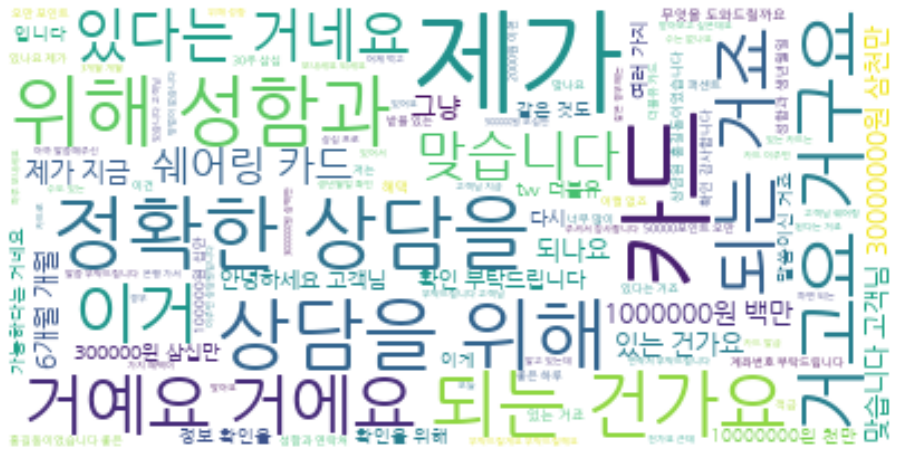

In [ ]:
plt.rcParams['figure.figsize'] = (16, 16)


wordcloud_n = WordCloud(max_font_size=50, max_words=100,font_path = path,background_color="white").generate(' '.join(filtered_sentence_n))



plt.imshow(wordcloud_n,interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
filtered_sentence_p = [token for token in tokens_p if not token in stop_words]
filtered_sentence_p 

['반갑습니다',
 'cs',
 '씨',
 '에스',
 '은행',
 '이대출',
 '상담사입니다',
 '무엇을',
 '도와',
 '드릴까요',
 '안녕하세요',
 '제가',
 '가지고',
 '있던',
 '적금',
 '통장',
 '2개',
 '두',
 '개',
 '중에',
 '1개',
 '한',
 '개',
 '해지하고',
 '싶어서',
 '전화드렸어요',
 '1개',
 '한',
 '개',
 '는',
 '자유식',
 '적금이고',
 '1개',
 '한',
 '개',
 '는',
 '정액적립식',
 '적금인데요',
 '2',
 '중에',
 '1개',
 '한',
 '개',
 '해지해야',
 '할',
 '같아요',
 '연말이라',
 '그런지',
 '목돈이',
 '필요해서요',
 '정액적립식은',
 '그대로',
 '유지하고',
 '자유식을',
 '해지하는',
 '게',
 '낫겠네요',
 '말씀하신',
 '것처럼',
 '더',
 '높은',
 '이자율을',
 '상품을',
 '가지고',
 '있는',
 '게',
 '더',
 '이득인',
 '거잖아요',
 '자유식',
 '적금을',
 '해지할게요',
 '해지하는',
 '거에',
 '있어서',
 '찾아보니까',
 '필요한',
 '서류들이',
 '많다고',
 '들었는데',
 '제가',
 '확인한',
 '게',
 '맞나',
 '봐주세요',
 '신분증',
 '사본',
 '통장',
 '사본',
 '입금받을',
 '제2통장',
 '통장',
 '사본이랑',
 '도장까지',
 '이렇게',
 '총',
 '4개',
 '개',
 '맞나요',
 '요즘',
 '코로나',
 '이슈도',
 '있고',
 '해서',
 '은행',
 '방문은',
 '어려울',
 '같은데',
 '따로',
 '팩스도',
 '팩스로',
 '보내서',
 '처리가',
 '가능한지도',
 '궁금합니다',
 '가능',
 '다행이네요',
 '비대면',
 '서비스가',
 '있어서',
 '편리하네요',
 '팩스',
 '번호는',
 '어디로',
 '보내면',
 '될까요',
 '그냥',
 '가장',
 '

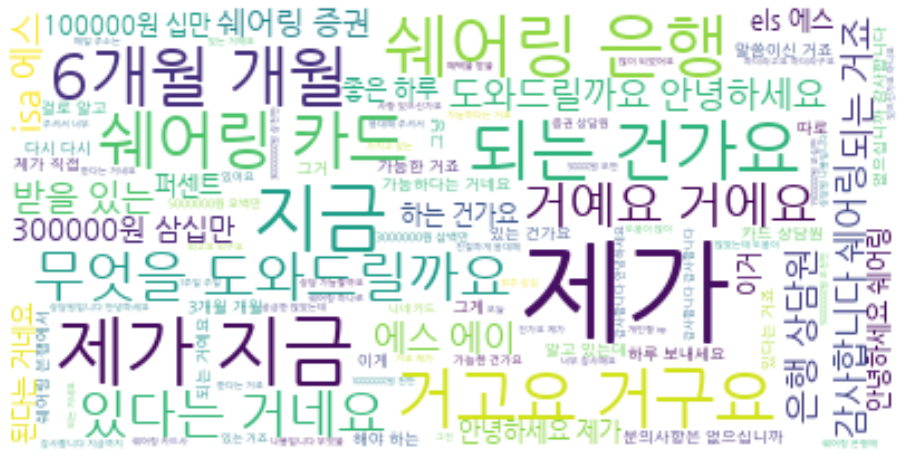

In [ ]:
wordcloud_p = WordCloud(max_font_size=50, max_words=100,font_path = path,background_color="white").generate(' '.join(filtered_sentence_p))


plt.imshow(wordcloud_p,interpolation="bilinear")
plt.axis("off")
plt.show()

1.0    12685
0.0     4498
Name: sentence2, dtype: int64

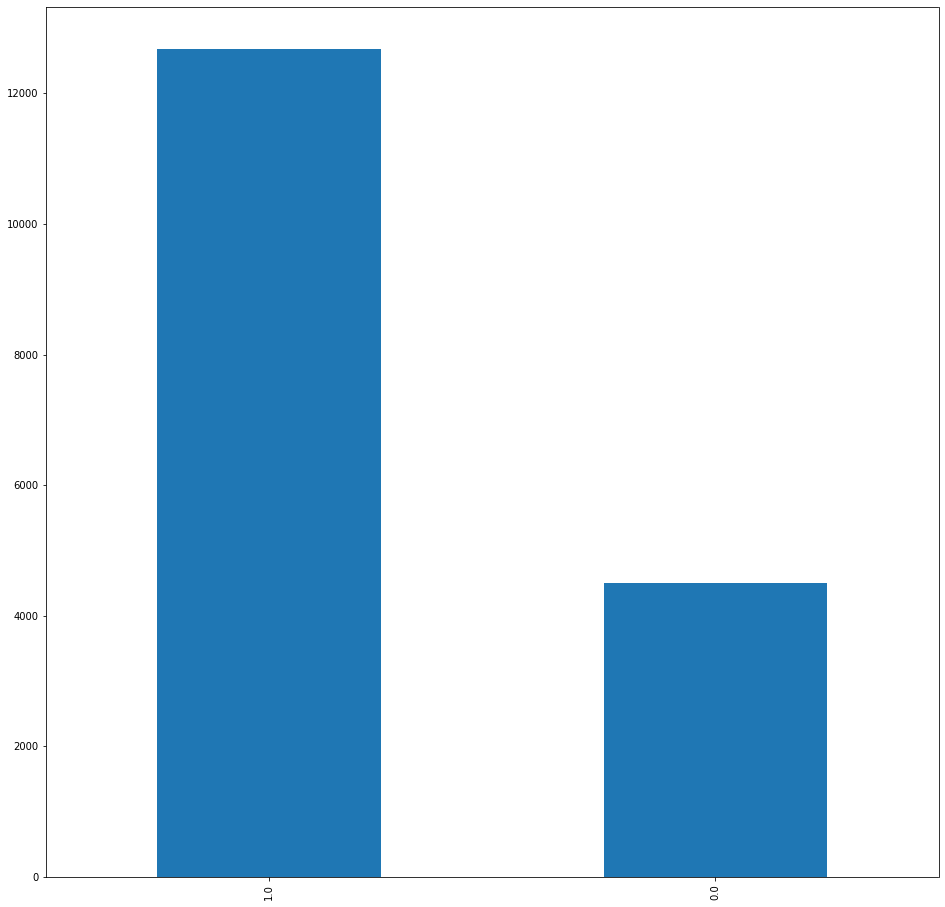

In [ ]:

df_2_cl['sentence2'].value_counts().plot(kind='bar')

df_2_cl['sentence2'].value_counts()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words = stop_words)


X = vectorizer.fit_transform(df_2_cl['sentence'].str.lower())


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '만은', '만이', '만큼', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서술한바와같이', '쓰여', '아니다', '아니라', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '어찌됏든', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '틀림없다', '편이', '하고', '하기', '하기만', '하는', '하는것만', '하는것이', '하다', '하면', '하지', '한하다', '할수록', '함으로써', '해도', '해서는', '형식으로', '힘이'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
X.shape

(17183, 20356)

In [ ]:
y = df_2_cl['sentence2']
y = y.to_numpy().ravel()

In [ ]:
vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '0001',
 '001111',
 '00년생',
 '01',
 '010',
 '01012345678',
 '01013452345',
 '01022223333',
 '0102569',
 '01025698795번',
 '01033335886',
 '01045676789',
 '030',
 '031',
 '080',
 '0포인트',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '1000000',
 '10000000',
 '100000000',
 '100000000원',
 '10000000원',
 '1000000원',
 '100000원',
 '100000포인트',
 '10000a',
 '10000ma',
 '10000mm',
 '10000원',
 '10000포인트',
 '1000원',
 '1000포인트',
 '10021667원',
 '100만원',
 '100불',
 '100원',
 '100일',
 '101동',
 '1020',
 '1020000원',
 '1022',
 '102동',
 '102호',
 '1032',
 '105동',
 '10가지',
 '10개',
 '10개월',
 '10년',
 '10년째',
 '10등급',
 '10매',
 '10분',
 '10시',
 '10월',
 '10일',
 '10종류',
 '11',
 '110',
 '1100000원',
 '1101호',
 '110333',
 '111',
 '1111',
 '111번지',
 '111이고요',
 '111이구요',
 '111호',
 '1121',
 '11378원',
 '1170000원',
 '119',
 '11년',
 '11동',
 '11번지',
 '11시',
 '11월',
 '11일',
 '12',
 '120000000원',
 '1200000원',
 '120000원',
 '12000원',
 '12100포인트',
 '1213',
 '1222',
 '123',
 '1230000원',
 '123000원',
 '12316',
 '1234',
 '12340

In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier


model = DecisionTreeClassifier()


model.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.9909064455114215
0.9258073901658423


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


models = []
models.append(('KNN', KNeighborsClassifier()))  # KNN 모델
models.append(('NB-M', MultinomialNB()))  # 멀티노미얼 나이브 베이즈
models.append(('NB-B', BernoulliNB()))  # 베르누이 나이브 베이즈 모델
models.append(('RF', RandomForestClassifier()))  # 랜덤포레스트 모델
models.append(('SVM', SVC(gamma='auto')))  # SVM 모델
models.append(('XGB', XGBClassifier()))  # XGB 모델

for name, model in models:
    model.fit(x_train, y_train)
    msg = "%s - train_score : %f, test score : %f" % (name, model.score(x_train, y_train), model.score(x_test, y_test))
    print(msg)

KNN - train_score : 0.928852, test score : 0.868199
NB-M - train_score : 0.877564, test score : 0.838813
NB-B - train_score : 0.897425, test score : 0.853360
RF - train_score : 0.990906, test score : 0.937445
SVM - train_score : 0.737960, test score : 0.739308
XGB - train_score : 0.779427, test score : 0.776840


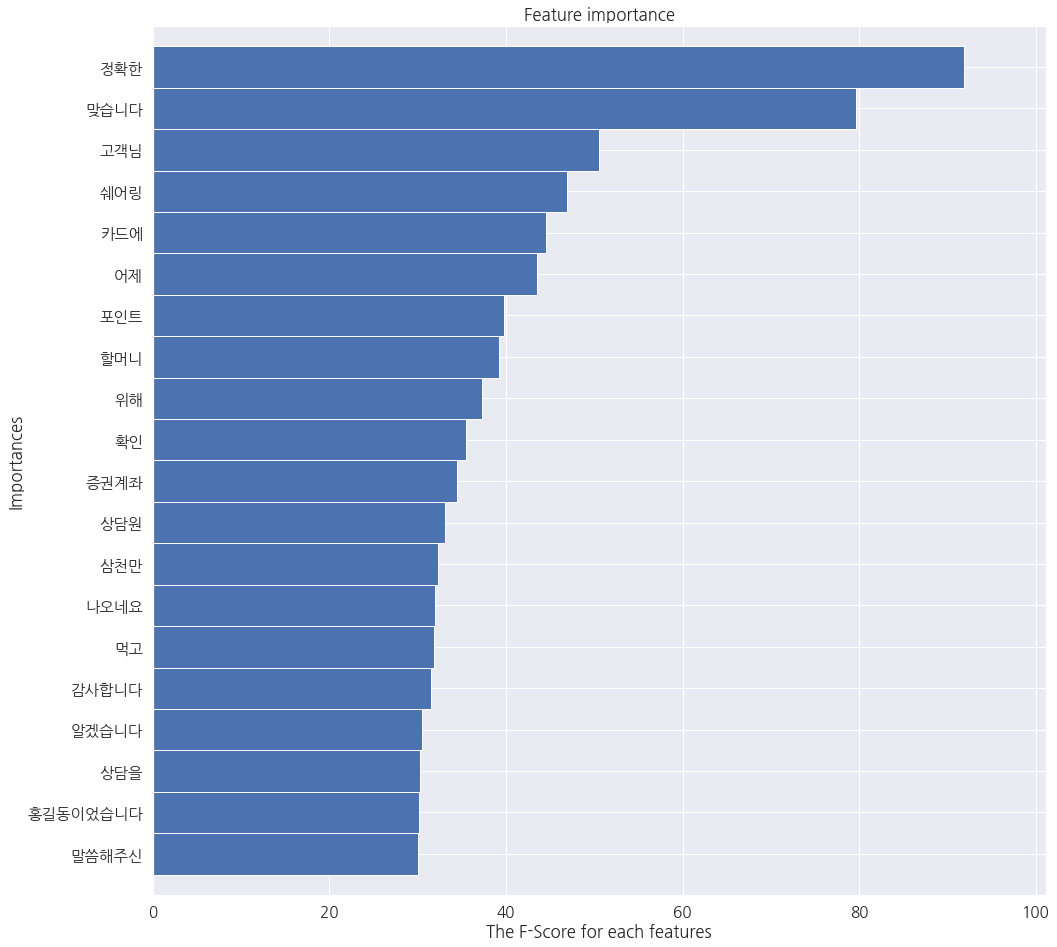

In [ ]:

max_num_features = 20
ax = xgb.plot_importance(models[-1][1], height = 1, grid = True, importance_type = 'gain', show_values = False, max_num_features = max_num_features)
ytick = ax.get_yticklabels()
word_importance = []
for i in range(max_num_features):
    word_importance.append(vectorizer.get_feature_names()[int(ytick[i].get_text().split('f')[1])])

ax.set_yticklabels(word_importance)

plt.rcParams['figure.figsize'] = (10, 15)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

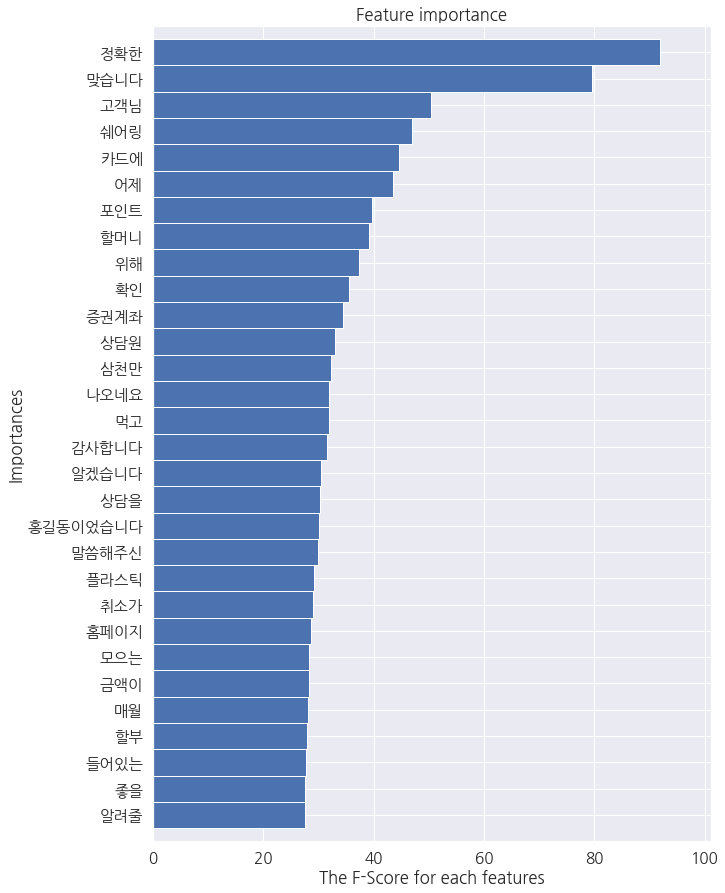

In [ ]:

max_num_features = 30
ax = xgb.plot_importance(models[-1][1], height = 1, grid = True, importance_type = 'gain', show_values = False, max_num_features = max_num_features)
ytick = ax.get_yticklabels()
word_importance = []
for i in range(max_num_features):
    word_importance.append(vectorizer.get_feature_names()[int(ytick[i].get_text().split('f')[1])])

ax.set_yticklabels(word_importance)

plt.rcParams['figure.figsize'] = (10, 15)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

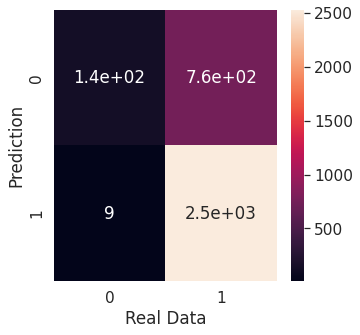

array([[ 138,  758],
       [   9, 2532]])

In [ ]:
from sklearn.metrics import confusion_matrix


model_predition = model.predict(x_test)


cm = confusion_matrix(y_test, model_predition)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
ax = sns.heatmap(cm, annot=True)
plt.xlabel('Real Data')
plt.ylabel('Prediction')
plt.show()
cm

In [ ]:

model_predition_xgb = models[-1][1].predict(x_test)


cm_xgb = confusion_matrix(y_test, model_predition_xgb)

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


print("Recall score: {}".format(recall_score(y_test, model_predition)))
print("Precision score: {}".format(precision_score(y_test, model_predition)))

Recall score: 0.9964580873671782
Precision score: 0.7696048632218845


In [ ]:

for i in range(5): 
    
    
    prediction = model.predict(x_test[i])
    print("{} 번째 테스트 데이터 문장: \n{}".format(i, df_2_cl['sentence'][i]))
    print("{} 번째 테스트 데이터의 예측 결과: {}, 실제 데이터: {}\n".format(i, prediction[0], y_test[i]))

0 번째 테스트 데이터 문장: 
반갑습니다. (CS)/(씨 에스) 은행, 이대출 상담사입니다. 무엇을 도와 드릴까요?
0 번째 테스트 데이터의 예측 결과: 1.0, 실제 데이터: 1.0

1 번째 테스트 데이터 문장: 
안녕하세요. 제가 가지고 있던 적금 통장 (2개)/(두 개) 중에 (1개)/(한 개)를 해지하고 싶어서 전화드렸어요. (1개)/(한 개)는 자유식 적금이고 (1개)/(한 개)는 정액적립식 적금인데요. (2)/(둘) 중에 (1개)/(한 개)를 해지해야 할 것 같아요. 연말이라 그런지 목돈이 좀 필요해서요.
1 번째 테스트 데이터의 예측 결과: 1.0, 실제 데이터: 1.0

2 번째 테스트 데이터 문장: 
자유식 적금에는 (1000000원)/(백만 원) 있고 정액적십+ 적립식에도 마찬가지로 (1000000원)/(백만 원) 정도 있는데요. 혹시 그(2)/(둘) 중에 어떤 상품을 해지하는 게 저한테는 더 이득인지 알 수 있을까요? 초반에 이자율에 대해서 확인해봤을 때 (2)/(둘) 다 (3%)/(삼 퍼센트) 정도로 비슷했던 u/.
2 번째 테스트 데이터의 예측 결과: 1.0, 실제 데이터: 1.0

3 번째 테스트 데이터 문장: 
자유식은 연 (2.8%)/(이 점 팔 퍼센트), 정액적립은 (3.0%)/(삼 점 영 퍼센트)입니다.
3 번째 테스트 데이터의 예측 결과: 1.0, 실제 데이터: 1.0

4 번째 테스트 데이터 문장: 
아, 그럼 정액적립식은 그대로 유지하고 자유식을 해지하는 게 낫겠네요? 말씀하신 것처럼 조금 더 높은 이자율을 상품을 가지고 있는 게 더 이득인 거잖아요.
4 번째 테스트 데이터의 예측 결과: 1.0, 실제 데이터: 1.0

